In [38]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt




In [39]:
keras.utils.set_random_seed(42)

# Cruide Oil WTI 

## 7:3

In [40]:
df= pd.read_csv('../dataset/Crude Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [41]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)

In [42]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
...,...,...,...,...,...,...,...
1289,2024-03-19,83.47,82.85,83.85,82.39,76810,0.91
1290,2024-03-20,81.68,83.20,83.21,81.44,26040,-2.14
1291,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54


In [43]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
...,...,...,...,...,...,...,...
1289,2024-03-19,83.47,82.85,83.85,82.39,76810,0.91
1290,2024-03-20,81.68,83.20,83.21,81.44,26040,-2.14
1291,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54


### Train, Test


In [44]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [45]:
X_train.shape

(885, 20, 1)

In [46]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2265
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023    
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014    
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013    
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013    
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012    
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [47]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [48]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 4.809948380960399
MAPE trên tập test là: 5.149090704180268 %
MDA trên tập test là: 49.04632152588556 %


In [49]:
# Dự báo giá trị 30 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [50]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,77.489555
1295,77.525436
1296,77.504524
1297,77.261566
1298,76.648460
1299,75.792557
1300,74.920883
1301,74.147789
1302,73.431892
1303,72.747772


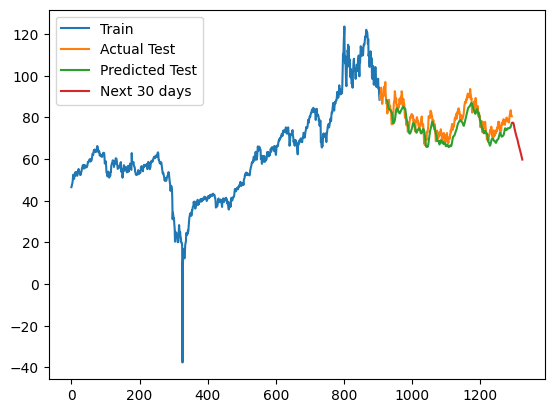

In [51]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()